In [117]:
import imghdr
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [67]:
extensions = ['jpg','jpeg','png','bmp']

In [68]:
for folder in os.listdir('data'):
    for image in os.listdir(os.path.join('data',folder)):
        image_path = os.path.join('data',folder,image)
        try:
            img = cv2.imread(image_path)
            ext = imghdr.what(image_path)
            if ext not in extensions:# os.remove(image_path)
                print('Image tip {} not in ext list {}'.format(ext,image_path))
                os.remove(image_path)
        except Exception:
            print('Cannot open file'.format(image_path))
            os.remove(image_path)

In [69]:
i = cv2.imread(os.path.join('data','happy','613k1XcpYCL.jpg'))

In [70]:
i.shape

(630, 1200, 3)

In [ ]:
plt.imshow(cv2.cvtColor(i,cv2.COLOR_BGR2RGB));

In [74]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 453 files belonging to 2 classes.


In [119]:
data

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [75]:
data_iterator = data.as_numpy_iterator()

In [102]:
batch = data_iterator.next()

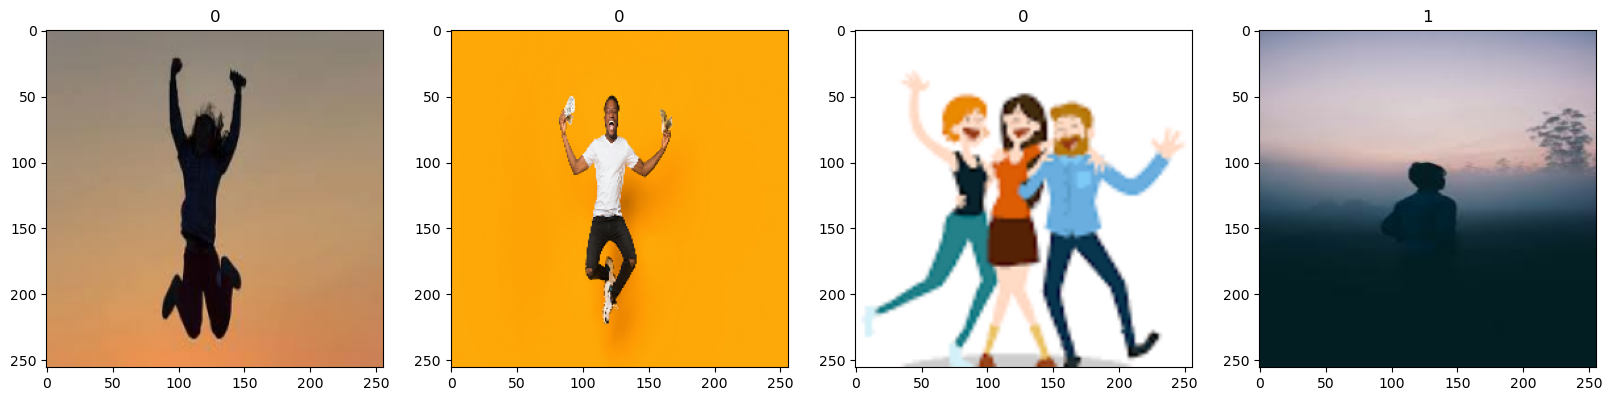

In [103]:
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for i, img in enumerate(batch[0][:4]):
    ax[i].imshow(img.astype(int))
    ax[i].title.set_text(batch[1][i])

In [104]:
data = data.map(lambda x,y:(x/255,y))

In [106]:
data.as_numpy_iterator().next()[0].shape

(32, 256, 256, 3)

In [115]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.15)
test_size = int(len(data)) - train_size - val_size
print(train_size)
print(val_size)
print(test_size)
print('total_length {}'.format(len(data)))

10
2
3
total_length 15


In [116]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [135]:
model = Sequential()

In [136]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [137]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [141]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 16)      

In [144]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
10/10 [==============================] - 15s 1s/step - loss: 0.8880 - accuracy: 0.5875 - val_loss: 0.8344 - val_accuracy: 0.4844
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 0.5348 - accuracy: 0.7000 - val_loss: 0.5255 - val_accuracy: 0.6875
Epoch 3/20
10/10 [==============================] - 13s 1s/step - loss: 0.4773 - accuracy: 0.7781 - val_loss: 0.3380 - val_accuracy: 0.8594
Epoch 4/20
10/10 [==============================] - 14s 1s/step - loss: 0.4410 - accuracy: 0.8250 - val_loss: 0.3642 - val_accuracy: 0.8438
Epoch 5/20
10/10 [==============================] - 13s 1s/step - loss: 0.3964 - accuracy: 0.8594 - val_loss: 0.3249 - val_accuracy: 0.8906
Epoch 6/20
10/10 [==============================] - 15s 1s/step - loss: 0.3848 - accuracy: 0.8406 - val_loss: 0.3918 - val_accuracy: 0.8281
Epoch 7/20
10/10 [==============================] - 15s 1s/step - loss: 0.2967 - accuracy: 0.8906 - val_loss: 0.2966 - val_accuracy: 0.8906
Epoch 8/20
10/10 [==

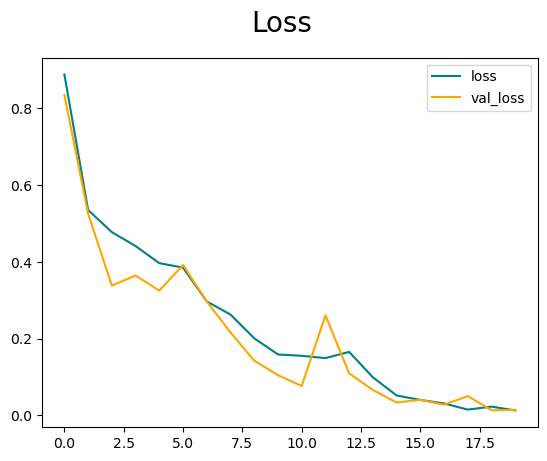

In [145]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

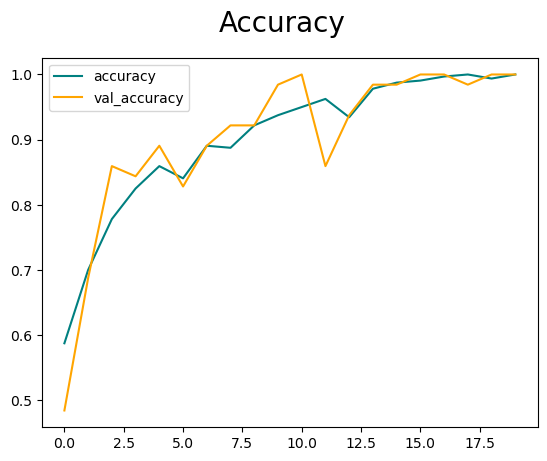

In [146]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [147]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [148]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [150]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 140ms/step


In [151]:
print(f'precision = {precision.result().numpy()}, recall = {recall.result()}, accuracy = {accuracy.result()}')

precision = 1.0, recall = 1.0, accuracy = 1.0


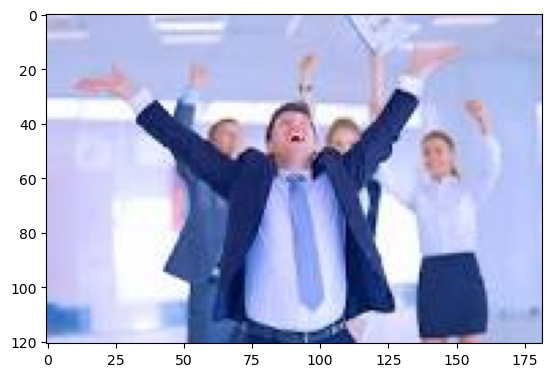

In [153]:
img = cv2.imread('happy_test.jpeg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

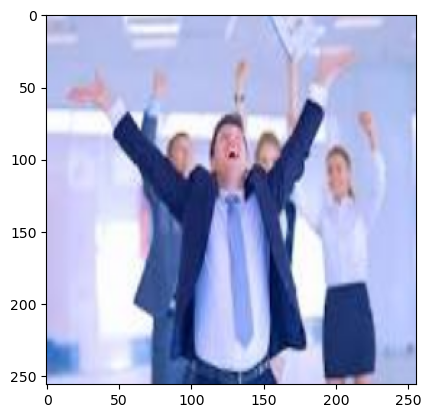

In [232]:
resize = tf.image.resize(img, (256,256))
s = resize.numpy().astype(int)
s = cv2.convertScaleAbs(s)
plt.imshow(cv2.cvtColor(s,cv2.COLOR_BGR2RGB));

In [233]:
y_pred = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 35ms/step


In [160]:
y_pred

array([[3.7262354e-05]], dtype=float32)

In [161]:
if y_pred > 0.5:
    print("This image belongs to class SAD")
else:
    print("This image belongs to class HAPPY")

This image belongs to class HAPPY


In [162]:
from tensorflow.keras.models import load_model

In [165]:
# model.save(os.path.join('models','HAPPY_OR_SAD.h5'))

In [180]:
new_model = load_model(os.path.join('models','HAPPY_OR_SAD.h5'))

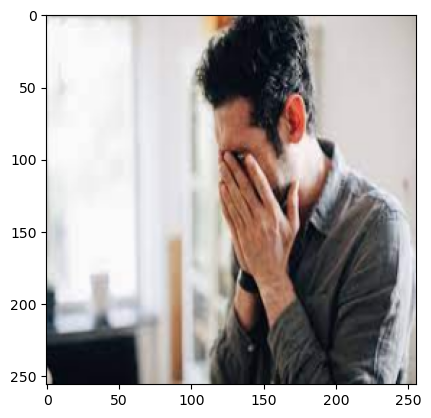

In [225]:
new_image = cv2.imread("sad_test.jpeg")
new_image_resized = tf.image.resize(new_image, (256,256))
t = new_image_resized.numpy().astype(int)
t = cv2.convertScaleAbs(t)
plt.imshow(cv2.cvtColor(t,cv2.COLOR_BGR2RGB));

In [223]:
new_y_pred = new_model.predict(np.expand_dims(new_image_resized/255, 0))
new_y_pred

1/1 [==============================] - 0s 35ms/step


array([[0.96491235]], dtype=float32)

In [212]:
if new_y_pred > 0.5:
    print("This image belongs to class SAD")
else:
    print("This image belongs to class HAPPY")

This image belongs to class SAD
